# Parameterization Tutorial

Welcome to this tutorial! Here we will see examples on using the WaveformUncertainty.py package to generate and parameterize gravitational waveform differences and then generate waveform uncertainties.

This code is still in early development and may change drastically!

Let's quickly look at the math behind what we are doing here:

The differences between two waveforms are defined in their amplitude difference and their phase difference.

Model amplitude difference is defined as a relative error between the amplitudes of two waveform models:

\begin{equation}
\nonumber
    \Delta{A}_{\mu}(f;\theta)= \begin{cases} 
      \frac{|\mu_{IMR}(f;\theta)|-|\mu_{EOB}(f;\theta)|}{|\mu_{IMR}(f;\theta)|} & f \leq f_{COR} \\
      \Delta{A}_{\mu}(f_{COR};\theta) & f > f_{COR} 
   \end{cases}
\end{equation}

f_COR is the frequency at which the model amplitude difference encounters a discontinuity. At that point, the curve is held constant.
f_COR is defined the following way:

\begin{equation}
\nonumber
    \frac{\partial^{2}}{\partial{f}^{2}}\left(\Delta{A}_{\mu}(f_{COR};\theta)\right)=-10^{-6}
\end{equation}

Model phase difference can be defined in two ways: raw phase difference and residual phase difference. Raw phase difference is just the difference between the phases of the waveform models. Residual phase difference is the same, but with any overall phase and time shifts removed. 

\begin{equation}
\nonumber
\Delta\phi_{\mu}(f;\theta)= \begin{cases} 
      \mathrm{tan}^{-1}\left(\frac{\mathrm{Im}[\mu_{IMR}(f;\theta)]}{\mathrm{Re}[\mu_{IMR}(f;\theta)]}\right)-\mathrm{tan}^{-1}\left(\frac{\mathrm{Im}[\mu_{EOB}(f;\theta)]}{\mathrm{Re}[\mu_{EOB}(f;\theta)]}\right) & f \leq f_{COR} \\
      \Delta\phi_{\mu}(f_{COR};\theta) & f > f_{COR} 
   \end{cases}
\end{equation}

\begin{equation}
\nonumber
\Delta\Phi_{\mu}(f;\theta)= \begin{cases} 
      \Delta\phi_{\mu}(f;\theta)-(2\pi{t}_{0}{f}+\phi_{0}) & f \leq f_{COR} \\
      \Delta\Phi_{\mu}(f_{COR};\theta) & f > f_{COR} 
   \end{cases}
\end{equation}

Amplitude and phase uncertainty are defined as the standard deviation of many draws of these waveform differences. In this case, we find the amplitude and phase uncertainties between two models:

\begin{equation}
\nonumber
\delta{A}_{\mu}(f)=\sqrt{\frac{\sum_{i=1}^{N}\left(\Delta{A}_{\mu}(f;\theta_{i})-\overline{\Delta{A}_{\mu}}(f)\right)}{N}}
\end{equation}

\begin{equation}
\nonumber
\delta\Phi_{\mu}(f)=\sqrt{\frac{\sum_{i=1}^{N}\left(\Delta\Phi_{\mu}(f;\theta_{i})-\overline{\Delta\Phi_{\mu}}(f)\right)}{N}}
\end{equation}

In practice, each array of waveform difference is quite large, and carrying around enough of them to find the uncertainties takes up a lot of space and takes a lot of time to generate. To get around this, we can parameterize the waveform difference arrays (within a small degree of error) as Chebyshev polynomial series. This way, we reduce the amount of data by over 99% and can save and load the data in seconds rather than having to regenerate the waveforms again. Mathematically, this looks like this:

\begin{equation}
\nonumber
\Delta{A}_{\mu}(f;\theta)\approx\Delta{A}_{T}(f;a,f_{COR},\Delta{A}_{\mu}(f_{COR};\theta))= \begin{cases} 
      \sum_{i=0}^{N-1}a_{i}T_{i}(f) & f \leq f_{COR} \\
      \Delta{A}_{\mu}(f_{COR};\theta) & f > f_{COR} 
   \end{cases}
\end{equation}

\begin{equation}
\nonumber
   \Delta\Phi_{\mu}(f;\theta)\approx\Delta\Phi_{T}(f;b,f_{COR},\Delta\Phi_{\mu}(f_{COR};\theta))= \begin{cases} 
      \sum_{i=0}^{N-1}b_{i}T_{i}(f) & f \leq f_{COR} \\
      \Delta\Phi_{\mu}(f_{COR};\theta) & f > f_{COR} 
   \end{cases}
\end{equation}

Now let's look at the code!

In [2]:
# Imports
# If you get an error message after running this, try again and it should go away!

import os
os.environ['LAL_DATA_PATH'] = '/home/carl-johan.haster/WaveForm_data/lalsuite-extra/data/lalsimulation'
import numpy as np
import bilby
import matplotlib.pyplot as plt
import sys
import scipy
import lal
import pesummary
from pesummary.gw.file.strain import StrainData
from pesummary.io import read

In [3]:
# Import the WaveformUncertainty package
# Make sure WaveformUncertainty.py and this notebook are in the same directory!

import WaveformUncertainty as wfu

In [4]:
# Set up a prior object using bilby from which we will draw our parameters
# This is based on GW170817

prior = bilby.core.prior.PriorDict()

prior['mass_1'] = bilby.core.prior.Uniform(name='mass_1',latex_label=r'$m_{1}$',minimum=1.37563293,maximum=1.80367393)
prior['mass_2'] = bilby.core.prior.Uniform(name='mass_2',latex_label=r'$m_{2}$',minimum=1.06371259,maximum=1.3758219)
prior['a_1'] = bilby.core.prior.Uniform(name='a_1',latex_label=r'$a_{1}$',minimum=0.0000027020166, maximum=0.04999694)
prior['a_2'] = bilby.core.prior.Uniform(name='a_2',latex_label=r'$a_{2}$',minimum=0.00000212868226, maximum=0.04998414)
prior['luminosity_distance'] = bilby.gw.prior.UniformSourceFrame(name='luminosity_distance',latex_label=r'$d_{L}$',minimum=12.27167145, maximum=52.94141976, unit='Mpc')
prior['phi_12'] = bilby.core.prior.Uniform(name='phi_12',latex_label=r'$\Phi_{12}$',minimum=0.00022415, maximum=6.28307139,boundary='periodic')
prior['phi_jl'] = bilby.core.prior.Uniform(name='phi_jl',latex_label=r'$\Phi_{JL}$',minimum=0.00038279, maximum=6.28301577,boundary='periodic')
prior['tilt_1'] = bilby.core.prior.Uniform(name='tilt_1',latex_label=r'$\theta_{1}$',minimum=0.00465234, maximum=3.12823758, boundary='periodic')
prior['tilt_2'] = bilby.core.prior.Uniform(name='tilt_2',latex_label=r'$\theta_{2}$',minimum=0.01877421, maximum=3.13573364, boundary='periodic')
prior['theta_jn'] = bilby.core.prior.Sine(name='theta_jn',latex_label=r'$\theta_{JN}$')
prior['phase'] = bilby.core.prior.Uniform(name='phase',latex_label=r'$\Phi$',minimum=0.000089295926, maximum=6.2830611, boundary='periodic')
prior['lambda_1'] = bilby.core.prior.Uniform(name="lambda_1",latex_label=r'$\Lambda_{1}$',minimum=0.00147326, maximum=3154.41685213)
prior['lambda_2'] = bilby.core.prior.Uniform(name="lambda_2",latex_label=r'$\Lambda_{2}$',minimum=0.02966776, maximum=4598.76616739)
prior['geocent_time'] = bilby.core.prior.Uniform(name="geocent_time",latex_label=r'$t_{c}$',minimum=1187008882.3, maximum=1187008882.5)
prior['dec'] = bilby.core.prior.DeltaFunction(name='dec',latex_label=r'$\delta$',peak=-0.408084)
prior['ra'] = bilby.core.prior.DeltaFunction(name='ra',latex_label=r'$\alpha_{r}$',peak=3.44616)
prior['psi'] = bilby.core.prior.DeltaFunction(name='psi',latex_label=r'$\Psi$',peak=1.56379256)

In [13]:
# Turn the prior object into a dictionary of 1000 random samples

parameter_data = wfu.parameter_dict_from_prior(prior,10000)

In [14]:
# Draw a random sample from the dictionary to be used as our injection
# If we want to choose which sample is returned, pass index={your_number}
# By default, we assume that the approximants can handle tides, but not precession. To change this, pass tides=False or precession=True

injection = wfu.injection(parameter_data)

In [15]:
# Set up our waveform generators with two approximants

waveform_arguments_1 = dict(waveform_approximant='IMRPhenomPv2_NRTidalv2', reference_frequency=50, 
                            catch_waveform_errors=True, f_low = 20.0, f_high=2048.0)

hf1 = bilby.gw.WaveformGenerator(parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
                    waveform_arguments=waveform_arguments_1,
                    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
                    parameters=injection,
                    sampling_frequency=4096, 
                    duration=256,
                )

waveform_arguments_2 = dict(waveform_approximant='SEOBNRv4T_surrogate', reference_frequency=50, 
                            catch_waveform_errors=True, f_low = 20.0, f_high=2048.0)

hf2 = bilby.gw.WaveformGenerator(parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
                    waveform_arguments=waveform_arguments_2,
                    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
                    parameters=injection,
                    sampling_frequency=4096, 
                    duration=256,
                )

In [16]:
# We generate our waveform differences
# Here, we do not pass PSD data, which will return raw phase difference

frequency_grid,amplitude_difference,raw_phase_difference,_,_,_ = wfu.fd_model_difference(hf1,hf2)

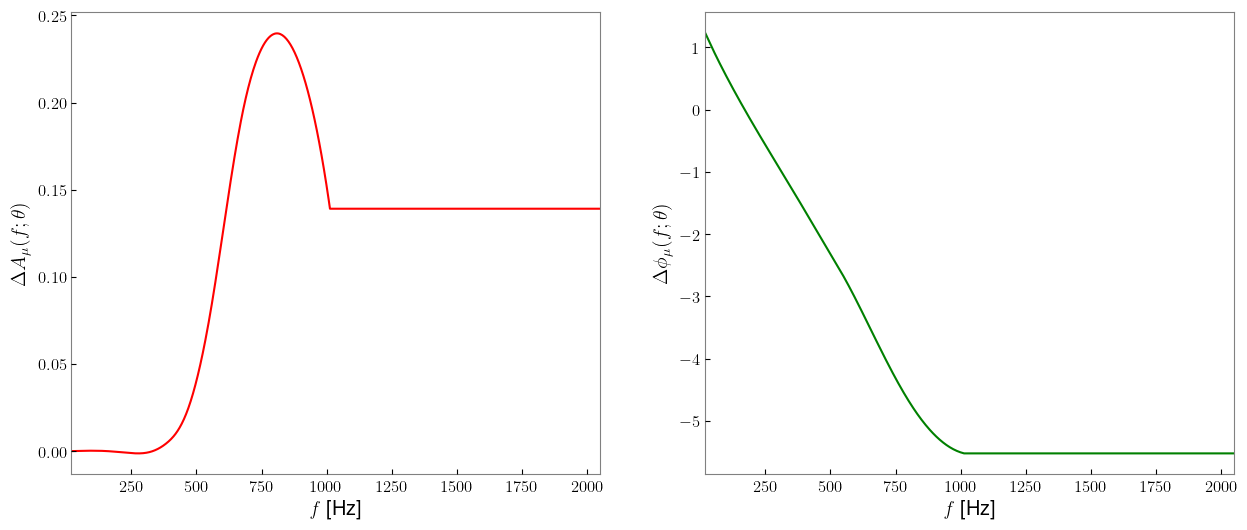

In [17]:
# Plotting our results!

fig,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].plot(frequency_grid,amplitude_difference,color='red')
ax[0].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[0].set_xlabel(r'$\mathit{f}$'+" [Hz]")
ax[0].set_ylabel(r'$\Delta{A}_{\mu}(f;\theta)$')
ax[0].tick_params(direction='in')
ax[0].grid(False)

ax[1].plot(frequency_grid,raw_phase_difference,color='green')
ax[1].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[1].set_xlabel(r'$\mathit{f}$'+" [Hz]")
ax[1].set_ylabel(r'$\Delta\phi_{\mu}(f;\theta)$')
ax[1].tick_params(direction='in')
ax[1].grid(False)

plt.show()

In [18]:
# Now, let's supply PSD data, which will return residual phase difference instead 

psd_data = np.loadtxt('https://dcc.ligo.org/public/0158/P1900011/001/GWTC1_GW170817_PSDs.dat',comments='#')

frequency_grid,amplitude_difference,residual_phase_difference,_,_,_ = wfu.fd_model_difference(hf1,hf2,psd_data=psd_data)

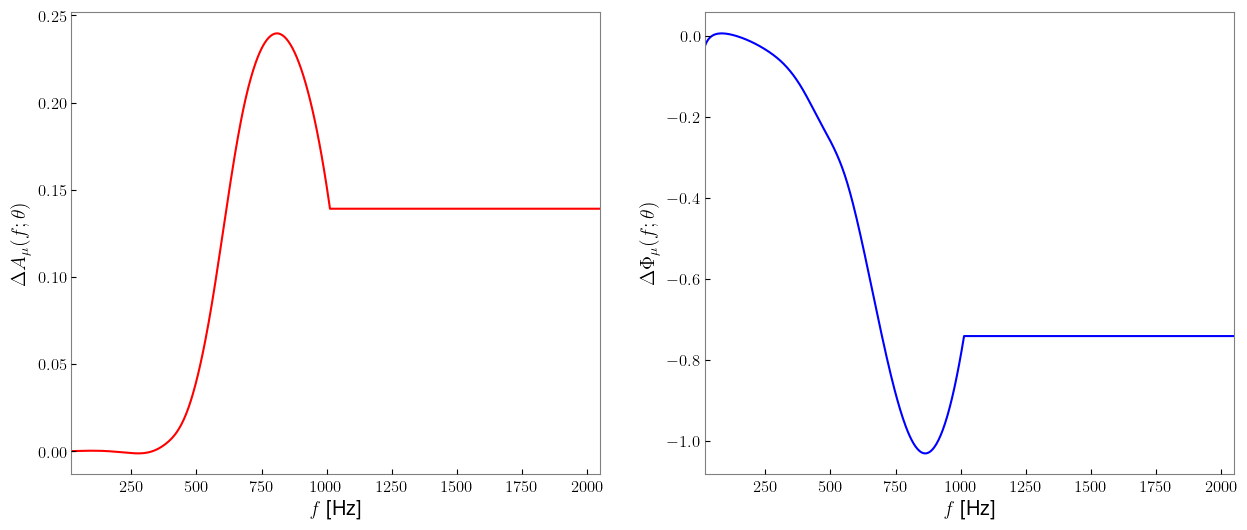

In [19]:
# Plotting our results!

fig,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].plot(frequency_grid,amplitude_difference,color='red')
ax[0].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[0].set_xlabel(r'$\mathit{f}$'+" [Hz]")
ax[0].set_ylabel(r'$\Delta{A}_{\mu}(f;\theta)$')
ax[0].tick_params(direction='in')
ax[0].grid(False)

ax[1].plot(frequency_grid,residual_phase_difference,color='blue')
ax[1].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[1].set_xlabel(r'$\mathit{f}$'+" [Hz]")
ax[1].set_ylabel(r'$\Delta\Phi_{\mu}(f;\theta)$')
ax[1].tick_params(direction='in')
ax[1].grid(False)

plt.show()

In [20]:
# If we want a large number of draws of waveform uncertainty, we use the __parameterization() function
# This essentially iterates the previous steps and saves the data as a series of Chebyshev coefficients
# The output is a numpy array that can be saved with numpy.save() as a .npy file and loaded with numpy.load()

parameterization = wfu.parameterization("IMRPhenomPv2_NRTidalv2","SEOBNRv4T_surrogate",parameter_data,100,psd_data=psd_data)

Parameterizing...
[====================================================================================================] 100.0% 
Done!

Time Elapsed: 65.199 seconds

Parameterized Model Difference data was created with 100 sample sets at a parameterization rate of 90.0901%.



In [26]:
# We can also load in pre-made parameterization matrices
# This one has 1000 parameterized waveform differences in it

parameterization = np.load('/home/ryanmatthew.johnson/Waveform_Uncertainty/files/parameterization_nsamples_1000.npy',allow_pickle=True)

In [28]:
# From the large set of parameterized waveform uncertainties, we can find the means and standard deviations

mean_amplitude_difference,amplitude_uncertainty,mean_phase_difference,residual_phase_uncertainty = wfu.uncertainties_from_parameterization(parameterization)

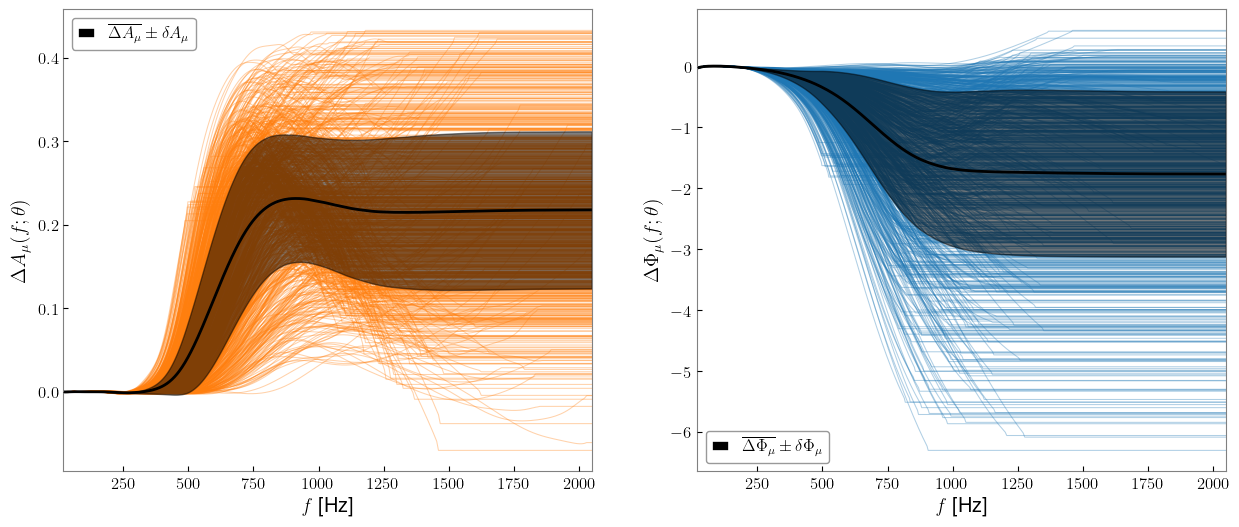

In [29]:
# Plotting our results!

fig,ax = plt.subplots(1,2,figsize=(15,6))

frequency_grid = parameterization[0][1]

for i in range(len(parameterization)):
    # Using __recovery_from_parameterization() to convert the Chebyshev coefficients back into the waveform uncertainties
    ax[0].plot(frequency_grid,wfu.recovery_from_parameterization('amplitude_difference',parameterization[i]),color='tab:orange',linewidth=0.75,alpha=0.35,zorder=1)
    ax[1].plot(frequency_grid,wfu.recovery_from_parameterization('phase_difference',parameterization[i]),color='tab:blue',linewidth=0.75,alpha=0.35,zorder=1)

ax[0].plot(frequency_grid,mean_amplitude_difference,color='k',linewidth=2,zorder=2,label=r'$\overline{\Delta{A}_{\mu}}\pm\delta{A}_{\mu}$')
ax[0].fill_between(frequency_grid,mean_amplitude_difference-amplitude_uncertainty,mean_amplitude_difference+amplitude_uncertainty,color='k',alpha=0.5,zorder=2)
ax[0].legend(fancybox=True,loc='upper left')
ax[0].grid(False)
ax[0].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[0].set_xlabel(r'$\mathit{f}$'+" [Hz]")
ax[0].set_ylabel(r'$\Delta{A}_{\mu}(f;\theta)$')
ax[0].tick_params(direction='in')

ax[1].plot(frequency_grid,mean_phase_difference,color='k',linewidth=2,zorder=2,label=r'$\overline{\Delta\Phi_{\mu}}\pm\delta\Phi_{\mu}$')
ax[1].fill_between(frequency_grid,mean_phase_difference-residual_phase_uncertainty,mean_phase_difference+residual_phase_uncertainty,color='k',alpha=0.5,zorder=2)
ax[1].legend(fancybox=True,loc='lower left')
ax[1].grid(False)
ax[1].set_xlim(frequency_grid[0],frequency_grid[-1])
ax[1].set_xlabel(r'$\mathit{f}$'+" [Hz]")
ax[1].set_ylabel(r'$\Delta\Phi_{\mu}(f;\theta)$')
ax[1].tick_params(direction='in')

plt.show()